# Simulation of observed spectrum

- author : Sylvie Dagoret-Campagne
- date jun 19th 2017

In [5]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print(theNotebook)

GenerateSimulationProfiles


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table, Column
import re
import os

In [8]:
import pandas as pd

In [20]:
!ls ../../spectrumsim


CTIOThroughput
CheckObsSpectra.ipynb
LSSTFiltersKG
SED_CALSPEC_Atm_CTIOTel.ipynb
SED_CALSPEC_Atm_filtLSSTKg.ipynb
TestCallSimRT.ipynb
atm-transm.png
lib
libCTIOSimuObsSpectra.py
libCTIOSimuObsSpectra_hd14943_2017_01_17.py
libradtransim
randomseed
simulations


### Import libradtan tools for simulation

In [21]:
import sys
sys.path.append('../../spectrumsim/libradtransim')

In [22]:
from libsimulateTranspCTIOScattAbs import *

### import pysynphot tools for CALSPEC SED

In [23]:
os.environ['PYSYN_CDBS']

'/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs'

In [24]:
import pysynphot as S
from astropy.io import ascii

### CTIO Properties

In [27]:
path_ctiodata='../../spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### esthetic

In [41]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [11]:
infos='ctio28may2017'

In [35]:
rootpath_rawimage="../OverScanRemove/trim_images"
MIN_IMGNUMBER=16
MAX_IMGNUMBER=25
object_name='HD11190'
SelectTagRe='^trim_20170528_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170528_[0-9]+.fits$'
calspec_sed='hd111980_stis_003.fits'
NBIMGPERLROW=4


In [12]:
logfile='logbk_'+object_name+'_'+infos+'.fits'
pandaslogfile='logbk_'+object_name+'_'+infos+'.csv'

In [75]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

## Get list of airmass

In [13]:
df=pd.read_csv(pandaslogfile)

In [65]:
df.head()

,Unnamed: 0,number,airmass,date,filename,exposure,zenith,temperature,pressure,humidity,windspeed,seeing,filter1,filter2
0,0,16,1.064,2017-05-28T23:58:55.250,../OverScanRemove/trim_images/,30.0,19.924000,4.5,778.0,54.0,3.2,1.470,dia,HoloAmAg
1,1,17,1.060,2017-05-29T00:01:23.455,../OverScanRemove/trim_images/,30.0,19.420000,4.6,778.0,55.0,4.3,1.502,dia,HoloAmAg
2,2,18,1.057,2017-05-29T00:04:04.404,../OverScanRemove/trim_images/,300.0,18.933001,4.5,778.0,55.0,3.4,1.651,dia,HoloAmAg
3,3,19,1.044,2017-05-29T00:17:02.352,../OverScanRemove/trim_images/,180.0,16.690001,4.8,778.0,55.0,5.7,2.441,dia,Thor300
4,4,20,1.036,2017-05-29T00:27:18.203,../OverScanRemove/trim_images/,180.0,15.087000,4.9,778.0,57.0,6.0,2.089,dia,HoloPhP


In [66]:
airmasses=df["airmass"]
date=df['date']
expo=df['exposure']
datafile=df['filename']
temperature=df['temperature']
pressure=df['pressure']
humidity=df['humidity']
seeing=df['seeing']
disperser=df['filter2']

## Get quantum efficiency

In [29]:
qe_fullfilename=os.path.join(path_ctiodata,qe_filename)

In [31]:
data_qe = np.loadtxt(qe_fullfilename)
wl_qe=data_qe[:,0]
tr_qe=data_qe[:,1]/100.

In [44]:
bp_ctio = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

## Get SED from CALSPEC 

- using Pysynphot

In [33]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [37]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

In [38]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed)
sed = S.FileSpectrum(filename)

In [63]:
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:03:03 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo

# Simulate atmosphere

In [52]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
PWV=4.
OZ=300.

In [53]:
for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    path,file=ProcessSimulation(am,PWV,OZ)   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1.06400001049
 2) pwv =  4.0
 2) oz =  300.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret-campagnesylvie/MacOsX/LSST/softs/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv40_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv40_oz30.OUT')
--------------------------------------------
 2) airmass =  1.05999994278
 2) pwv =  4.0
 2) oz =  300.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv

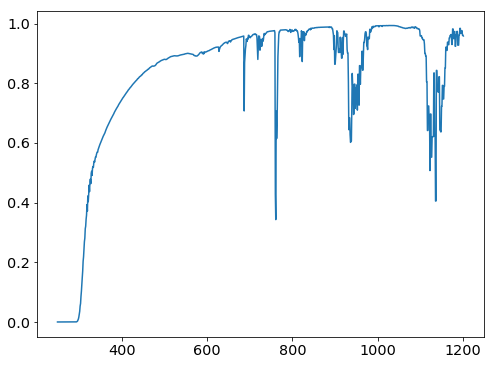

In [50]:
plt.plot(all_wl_atm[1],all_tr_atm[1])

In [55]:
all_bp_atm[0].wave

array([  2500.,   2510.,   2520.,   2530.,   2540.,   2550.,   2560.,
         2570.,   2580.,   2590.,   2600.,   2610.,   2620.,   2630.,
         2640.,   2650.,   2660.,   2670.,   2680.,   2690.,   2700.,
         2710.,   2720.,   2730.,   2740.,   2750.,   2760.,   2770.,
         2780.,   2790.,   2800.,   2810.,   2820.,   2830.,   2840.,
         2850.,   2860.,   2870.,   2880.,   2890.,   2900.,   2910.,
         2920.,   2930.,   2940.,   2950.,   2960.,   2970.,   2980.,
         2990.,   3000.,   3010.,   3020.,   3030.,   3040.,   3050.,
         3060.,   3070.,   3080.,   3090.,   3100.,   3110.,   3120.,
         3130.,   3140.,   3150.,   3160.,   3170.,   3180.,   3190.,
         3200.,   3210.,   3220.,   3230.,   3240.,   3250.,   3260.,
         3270.,   3280.,   3290.,   3300.,   3310.,   3320.,   3330.,
         3340.,   3350.,   3360.,   3370.,   3380.,   3390.,   3400.,
         3410.,   3420.,   3430.,   3440.,   3450.,   3460.,   3470.,
         3480.,   34

In [59]:
all_bp_atm[0].throughput

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   8.51186500e-06,
         4.25381800e-05,   1.10379700e-04,   3.25336800e-04,
         6.53280500e-04,   1.73709700e-03,   3.12468500e-03,
         6.30204800e-03,

## Observed spectra

- calculate the observed spectra and save it in list

In [77]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []

for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    atm_filter_name='CTIO atm {}'.format(idx)
    the_bp_atm=bp_atm = S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    bp_ctio_atm = bp_ctio*the_bp_atm # Multply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    


((CTIO QE * CTIO atm 0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((CTIO QE * CTIO atm 7)) does not have a defined binset in the wavecat table. The waveset of the spectru

In [78]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1]
    return dataout

In [73]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes)

10  ,  4814


## Save output file

In [79]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,overwrite=True)